In [1]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict

/home/vincenzo/miniconda3/envs/radio_sunburst_data_creation/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import os
import pandas as pd

# Base directory path
base_dir = '/mnt/nas05/data01/vincenzo/ecallisto/data'

# List to store paths and metadata
data = []

# Traverse the directory structure
for antenna_name in os.listdir(base_dir):
    antenna_path = os.path.join(base_dir, antenna_name)
    if os.path.isdir(antenna_path):
        for burst_type in os.listdir(antenna_path):
            burst_path = os.path.join(antenna_path, burst_type)
            if os.path.isdir(burst_path):
                for parquet_file in os.listdir(burst_path):
                    if parquet_file.endswith('.parquet'):
                        file_path = os.path.join(burst_path, parquet_file)
                        # Extract datetime start from file name
                        datetime_start = parquet_file.split('.')[0]
                        # Append path and metadata to the list
                        data.append({
                            'file_path': file_path,
                            'antenna_name': antenna_name,
                            'burst_type': burst_type,
                            'datetime_start': datetime_start
                        })

# Create a pandas dataframe from the list
df_paths = pd.DataFrame(data)

# Display the dataframe
print(df_paths.head())


                                           file_path         antenna_name  \
0  /mnt/nas05/data01/vincenzo/ecallisto/data/MEXI...  MEXICO-FCFM-UANL_01   
1  /mnt/nas05/data01/vincenzo/ecallisto/data/MEXI...  MEXICO-FCFM-UANL_01   
2  /mnt/nas05/data01/vincenzo/ecallisto/data/MEXI...  MEXICO-FCFM-UANL_01   
3  /mnt/nas05/data01/vincenzo/ecallisto/data/MEXI...  MEXICO-FCFM-UANL_01   
4  /mnt/nas05/data01/vincenzo/ecallisto/data/MEXI...  MEXICO-FCFM-UANL_01   

  burst_type       datetime_start  
0          3  2024-05-08_21-39-00  
1          3  2024-02-01_17-13-00  
2          3  2024-02-07_16-07-00  
3          3  2024-03-25_14-49-00  
4          3  2024-02-10_20-23-00  


In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd

def custom_stratified_split(df, test_size=0.1, val_size=0.1, min_size=3):
    """
    Custom stratified split function to handle groups of different sizes.
    
    Parameters:
    - df: Input DataFrame containing the data to be split.
    - test_size: Proportion of the dataset to include in the test split.
    - val_size: Proportion of the dataset to include in the validation split.
    - min_size: Minimum size of a group to apply standard splitting.
    
    Returns:
    - train_df: DataFrame containing the training data.
    - val_df: DataFrame containing the validation data.
    - test_df: DataFrame containing the test data.
    """
    def split_group(group_df):
        if len(group_df) < min_size:
            # Handle very small groups
            if len(group_df) == 1:
                return group_df, pd.DataFrame(), pd.DataFrame()
            elif len(group_df) == 2:
                train = group_df.sample(n=1, random_state=42)
                return train, pd.DataFrame(), group_df.drop(train.index)
            else:
                train, test_val = train_test_split(group_df, test_size=2, random_state=42)
                val, test = train_test_split(test_val, test_size=1, random_state=42)
                return train, val, test
        else:
            # Standard split for larger groups
            train_val, test = train_test_split(group_df, test_size=test_size, random_state=42)
            train, val = train_test_split(train_val, test_size=val_size/(1-test_size), random_state=42)
            return train, val, test

    # Group the DataFrame by 'antenna' and 'label'
    grouped = df.groupby(['antenna_name', 'burst_type'])
    train_list, val_list, test_list = [], [], []

    for _, group in grouped:
        train, val, test = split_group(group)
        train_list.append(train)
        val_list.append(val)
        test_list.append(test)

    # Concatenate all the splits back into DataFrames
    train_df = pd.concat(train_list)
    val_df = pd.concat(val_list)
    test_df = pd.concat(test_list)

    return train_df, val_df, test_df

In [10]:
train_df, val_df, test_df = custom_stratified_split(df_paths)
# Verify no overlap
assert len(set(train_df['file_path']).intersection(set(val_df['file_path']))) == 0, "Overlap between train and validation sets"
assert len(set(train_df['file_path']).intersection(set(test_df['file_path']))) == 0, "Overlap between train and test sets"
assert len(set(val_df['file_path']).intersection(set(test_df['file_path']))) == 0, "Overlap between validation and test sets"
print("No overlap verified between splits.")
# Display the split dataframes
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

No overlap verified between splits.
Train set size: 243677
Validation set size: 30534
Test set size: 30549


/tmp/ipykernel_3209715/1006725076.py:10: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  date_range_per_antenna = test_df.groupby('antenna_name')['datetime_start'].agg([min, max])
/tmp/ipykernel_3209715/1006725076.py:10: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  date_range_per_antenna = test_df.groupby('antenna_name')['datetime_start'].agg([min, max])


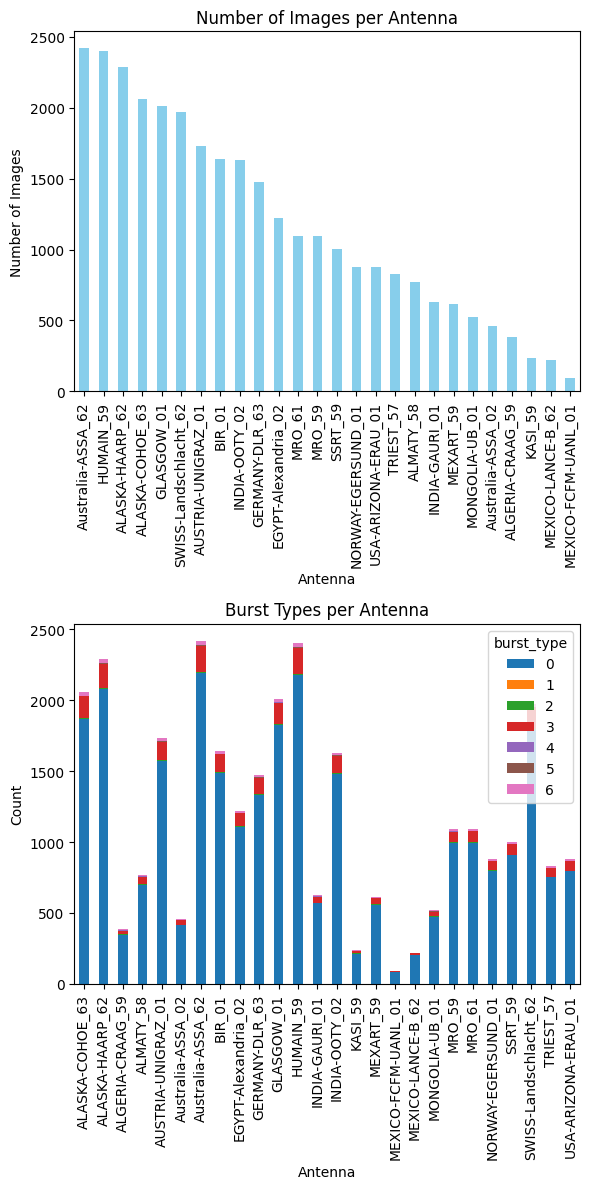

In [11]:
# EDA
import matplotlib.pyplot as plt
# Number of images per antenna
images_per_antenna = test_df['antenna_name'].value_counts()

# Number of burst types per antenna
burst_types_per_antenna = test_df.groupby('antenna_name')['burst_type'].value_counts().unstack(fill_value=0)

# Date range per antenna
date_range_per_antenna = test_df.groupby('antenna_name')['datetime_start'].agg([min, max])

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(6, 12))

# Images per antenna
images_per_antenna.plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Number of Images per Antenna')
ax[0].set_xlabel('Antenna')
ax[0].set_ylabel('Number of Images')

# Burst types per antenna
burst_types_per_antenna.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Burst Types per Antenna')
ax[1].set_xlabel('Antenna')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [12]:
from datasets import Dataset, DatasetDict

def paths_to_hf_dataset(df):
    data = []
    for _, row in df.iterrows():
        data.append({
            'file_path': row['file_path'],
            'label': row['burst_type'],
            'antenna': row['antenna_name'],
            'datetime': row['datetime_start']
        })
    return Dataset.from_list(data)

# Convert each split to a Hugging Face dataset
train_ds = paths_to_hf_dataset(train_df)
val_ds = paths_to_hf_dataset(val_df)
test_ds = paths_to_hf_dataset(test_df)

# Create a dataset dictionary
dataset_dict = DatasetDict({
    'train': train_ds,
    'validation': val_ds,
    'test': test_ds
})
